**IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**DATA PREPERATION**

In [2]:
#data collection
#loading dataset into pandas dataframe
train_df = pd.read_csv(r"C:\Users\Lenovo\ProjData\Web-Dev-AI-ML-GDG\Fake News Detector\dataset\train.csv")

In [3]:
train_df.head(15)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [4]:
# Include error handling for missing data
train_df[train_df['text'].isnull()]['title'].tolist()

['Gorafi Magazine : Entretien exclusif avec Barack Obama « Plus rien à secouer. Démerdez-vous » >> Le Gorafi',
 'Le top des recherches Google passe en top des recherches Google >> Le Gorafi',
 'La Corée du Nord annonce avoir envoyé un missile balistique de félicitation à Donald Trump >> Le Gorafi',
 'Grand-Prix du Brésil – Romain Grosjean obtient le meilleur temps dans la ligne droite des stands >> Le Gorafi',
 'Gorafi Magazine: Barack Obama « Je vous ai déjà dit que j’en avais plus rien à battre. Lâchez moi maintenant » >> Le Gorafi',
 '#NDDL: Pour fêter l’autorisation des travaux, Manuel Valls détruit personnellement plusieurs hectares de zone humide >> Le Gorafi',
 '«Pourquoi je suis candidat à la présidentielle 2017» par Jean-François Buissière, candidat à la présidentielle 2017 >> Le Gorafi',
 'GuinessBook : 100 millions d’Américains battent ensemble le record d’apnée >> Le Gorafi',
 'Les Américains ne sont plus qu’à quelques heures d’être enfin tranquilles pour quatre ans >> Le G

All the missing texts seem to be from articles of Le Gorafi magazine, which is a news satire website.

The text field can be filled with the translation of the French titles.

In [5]:
# Using the simpler French-English translator from nltk (multilingual translator)
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
from nltk.corpus import wordnet

def translate_word(word):
    synsets = wordnet.synsets(word, lang='fra')  # Look up French word
    if synsets:
        return synsets[0].lemmas('eng')[0].name()  # Get first English lemma
    return word  # Return the same word if no translation is found

def translate_title_nltk(title):
    if pd.isna(title):  # Check if title is NaN
        return None
    words = title.split()
    translated_words = [translate_word(word) for word in words]
    return ' '.join(translated_words)

# Apply translation only where 'text' is null
train_df.loc[train_df['text'].isnull(), 'text'] = train_df['title'].apply(translate_title_nltk)

In [7]:
train_df[train_df['text'].isnull()]['text'].tolist()

[]

All the nulls texts have been dealt.

In [8]:
#deleting unwanted columns
train_df = train_df.drop("author", axis = 1)
train_df = train_df.drop("title", axis = 1)
train_df = train_df.drop("id", axis = 1)

In [9]:
train_df.shape

(20800, 2)

In [10]:
train_df.head(15)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \r\nAn Iranian woman has been sentenced ...,1
5,"In these trying times, Jackie Mason is the Voi...",0
6,Ever wonder how Britain’s most iconic pop pian...,1
7,"PARIS — France chose an idealistic, traditi...",0
8,Donald J. Trump is scheduled to make a highly ...,0
9,A week before Michael T. Flynn resigned as nat...,0


<Axes: xlabel='label', ylabel='count'>

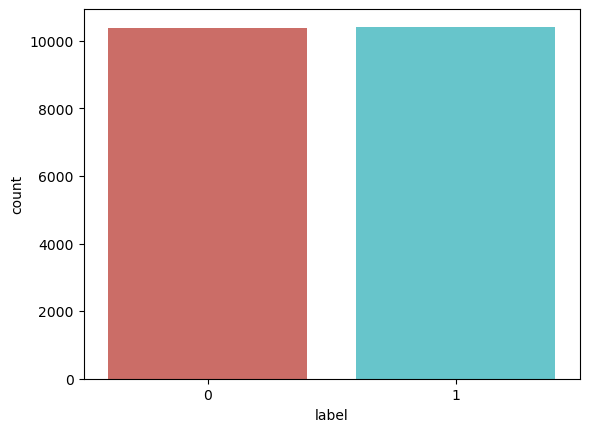

In [11]:
def create_distribution(dataFile):
    return sb.countplot(x='label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_df)

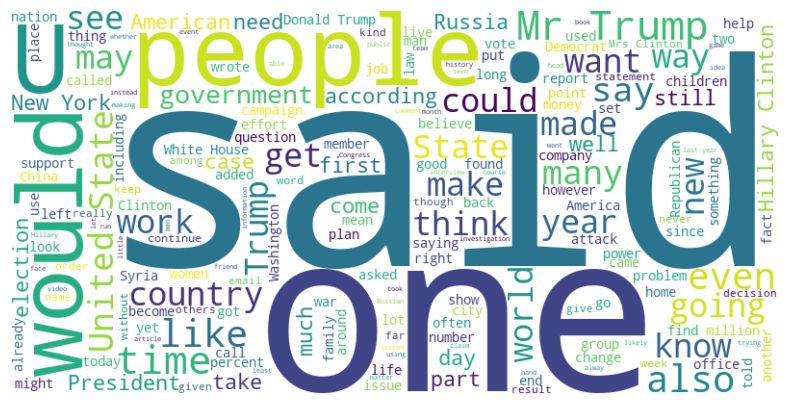

In [12]:
# Word cloud creation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# creating a single string out of all the text data
text_data = " ".join(train_df['text'].dropna()) 

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
def data_qualityCheck():
    print("Checking data qualitites...")
    train_df.isnull().sum()
    train_df.info()  
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20800 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB
check finished.


In [14]:
train_df = train_df.dropna()

In [15]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20800 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB
check finished.


In [16]:
train_df.shape

(20800, 2)

In [17]:
train_df.head(10)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \r\nAn Iranian woman has been sentenced ...,1
5,"In these trying times, Jackie Mason is the Voi...",0
6,Ever wonder how Britain’s most iconic pop pian...,1
7,"PARIS — France chose an idealistic, traditi...",0
8,Donald J. Trump is scheduled to make a highly ...,0
9,A week before Michael T. Flynn resigned as nat...,0


In [18]:
train_df.reset_index(drop= True,inplace=True)

In [19]:
train_df.head(10)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \r\nAn Iranian woman has been sentenced ...,1
5,"In these trying times, Jackie Mason is the Voi...",0
6,Ever wonder how Britain’s most iconic pop pian...,1
7,"PARIS — France chose an idealistic, traditi...",0
8,Donald J. Trump is scheduled to make a highly ...,0
9,A week before Michael T. Flynn resigned as nat...,0


In [20]:
label_train = train_df.label

In [21]:
label_train.head(10)

0    1
1    0
2    1
3    1
4    1
5    0
6    1
7    0
8    0
9    0
Name: label, dtype: int64

In [22]:
train_df = train_df.drop("label", axis = 1)

In [23]:
train_df.head(10)

,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,Ever get the feeling your life circles the rou...
2,"Why the Truth Might Get You Fired October 29, ..."
3,Videos 15 Civilians Killed In Single US Airstr...
4,Print \r\nAn Iranian woman has been sentenced ...
5,"In these trying times, Jackie Mason is the Voi..."
6,Ever wonder how Britain’s most iconic pop pian...
7,"PARIS — France chose an idealistic, traditi..."
8,Donald J. Trump is scheduled to make a highly ...
9,A week before Michael T. Flynn resigned as nat...


In [24]:
train_df['text'][2188]

'Comments Actor Steven Seagal has just stood up for America, while the rest of Hollywood remains silent. This week has been rough for our country. First, Democratic nominee Hillary Clinton collapsed at the 9/11 memorial. Then, she called millions of hardworking Americans “deplorable.” As if that weren’t enough, NFL players throughout the country have been blatantly disrespecting the American flag. Needless to say, Seagal had enough. “I think the most important job as Secretary of State is ensuring our people don’t get killed,” Seagal tweeted. “If you can’t do [email protected] “Pneumonia or not, she is going to be disastrous for the American people. #NoToHillary,” he continued. Of course, Seagal quickly became the target of liberal fire for his comments, but he refused to break down. He particularly lost it when one Twitter user tried to argued that Hillary was the most capable for the presidency. “Capable? Capable of leaving AMERICANS to die. Capable of disregarding law. Capable of di

**PRE PROCESSING OF DATA**

In [25]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [26]:
stpwrds

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

**LEMMATIZATION**

Lemmatization is the process of reducing words to their base or dictionary form, known as the "lemma." 
In natural language processing (NLP), lemmatization is an important technique used to normalize text data by removing 			  inflections, conjugations, and other variations of a word to bring them to their root form.

         example:the word "cats" can be lemmatized to "cat",
		 	    "running" to "run", 
		 	    "am" to "be"
		 	    "ate" to "eat"
Lemmatization is similar to stemming, but it produces more accurate results because it takes into account the context of the 			word in a sentence and uses more advanced linguistic analysis to identify the base form.
Lemmatization can improve the accuracy of text analysis and machine learning models that rely on text data.

In [27]:
#lemmatization
for x in range(len(train_df)) :
    corpus = []
    review = train_df['text'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    train_df['text'][x] = review      

In [28]:
train_df['text'][2182]

'vin scully conclude run voice dodger oct game giant att park san francisco local event scullys fan los angeles area baseball greatest announcer retires national occasion tb major league baseball partner sunday afternoon broadcast bring last scully rest country tb saying network decide matchup televise seven day beforehand simulcasting game easy choice scully leaving game may well playoff implication viable possibility tb david ortiz boston red sox designated hitter retiring season race american league east could decided day tb may see still possibility game final day regular season start little p eastern game might entice network tb produce game accustomed picking local simulcast unusual occasion necessary permission major league baseball sportsnet la dodger network would likely granted quickly assuming approval given tb could carry scully game cut boston whenever ortiz batting tb take ortiz broadcast one baseball national partner ought get k pick scully game espn showing w n b playof

**SPLITTING THE DATASET INTO TRAINING DATA & TEST DATA:**

In [29]:
#splitting the dataset to training and test dataset,80% data to be training data &20% will be testing data.(ie test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(train_df['text'], label_train, test_size=0.2, random_state=0)

In [30]:
X_train

15902    trump reopening reversing rome bid greatest am...
7375     washington three year ago president barack oba...
4889     tuesday russian admiral kuznetsov aircraftcarr...
2143     called yonsei beach club convened last time so...
18373    join u new york primary live update may indian...
                               ...                        
13123    paypal cofounder peter thiel received ton crit...
19648                            obamas weakness dangerous
9845     city state official new york agreed pay two me...
10799    secret relationship made two men rich one head...
2732     filmmaker michael moore attend woman march was...
Name: text, Length: 16640, dtype: object

In [31]:
X_train.shape

(16640,)

In [32]:
Y_train

15902    1
7375     0
4889     1
2143     0
18373    0
        ..
13123    1
19648    1
9845     0
10799    0
2732     0
Name: label, Length: 16640, dtype: int64

**CONVERTING THE TEXTUAL DATA TO NUMERICAL DATA**

converting to textual data into numerical data/feature vector

1)**tf (term freequency)**:-which counts the number of time a perticular words is repearting in a documents.

2)**idf (inverse document freequency)**:-Measure the word is a rare word or common word in a document

In [33]:
#converting to textual data into numerical data/feature vector

tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [34]:
print(tfidf_X_train,tfidf_X_test)

  (0, 101958)	0.013731296821164335
  (0, 51903)	0.015836345135707194
  (0, 33854)	0.027419440558230104
  (0, 78291)	0.04361983044051221
  (0, 26396)	0.048878189841861444
  (0, 33154)	0.03847252053348699
  (0, 27735)	0.037705932603892926
  (0, 126352)	0.06410156021981164
  (0, 21166)	0.025479722971281215
  (0, 43602)	0.0203473786050606
  (0, 40134)	0.028468620896584956
  (0, 25485)	0.030709222007177926
  (0, 115892)	0.02569824764897835
  (0, 2206)	0.02202145184530765
  (0, 64084)	0.025198332768318534
  (0, 10828)	0.026047989313553725
  (0, 20831)	0.024932668027013327
  (0, 35749)	0.024836155142315512
  (0, 121057)	0.051137142070492095
  (0, 141870)	0.026186707344106518
  (0, 128685)	0.021575349226512993
  (0, 26658)	0.04153430056147489
  (0, 51405)	0.0405389910791618
  (0, 12525)	0.0203473786050606
  (0, 55408)	0.021926621036885228
  :	:
  (16639, 29361)	0.042716858679727555
  (16639, 140619)	0.02721876516175294
  (16639, 143564)	0.0355435020177999
  (16639, 100831)	0.041552537228145454

In [35]:
tfidf_X_train.shape

(16640, 146701)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**CLASSIFICATION MODEL:-PASSIVE AGGRESSIVE CLASSIFIER**

Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example.

Passive-Aggressive algorithms are generally used for large-scale learning. It is one of the few 'online-learning algorithmns. In online machine learning algorithms, the input data comes in sequential order and the machine learning model is updated step-by-step, as opposed to batch learning, where the entire training dataset is used at once. This is very useful in situations where there is a huge amount of data and it is computationally infeasible to train the entire dataset because of the sheer size of the data. We can simply say that an online-leaming algorithm will get a training example, update the classifier, and then throw away the example.

In [37]:
#model and model training

classifier = PassiveAggressiveClassifier()
classifier.fit(tfidf_X_train,Y_train)

PassiveAggressiveClassifier()

**ACCURACY SCORE & CONFUSION MATRIX**

Accuracy: 95.38%
Confusion matrix, without normalization


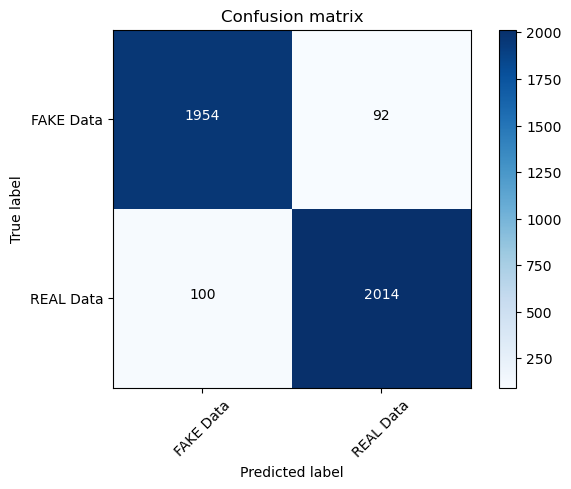

In [38]:
#accuracy score on the test data
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

**CLASSIFICATION REPORT**

In [39]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2046
           1       0.96      0.95      0.95      2114

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



**CROSS VALIDATION**

In [41]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
# Perform Cross-Validation
scoring_metrics = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score)
}

cv_results = cross_validate(classifier, tfidf_X_train, Y_train, cv=5, scoring=scoring_metrics)

# Print Average Scores
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Mean Recall: {cv_results['test_recall'].mean():.4f}")
print(f"Mean F1 Score: {cv_results['test_f1'].mean():.4f}")

Mean Accuracy: 0.9558
Mean Precision: 0.9518
Mean Recall: 0.9601
Mean F1 Score: 0.9559


**SAVING & LOADING MODEL**

In [36]:
#pickling the model into disk
pickle.dump(classifier,open('./model.pkl', 'wb'))
pickle.dump(tfidf_v,open('vector.pkl', 'wb'))

In [37]:
# load the model from disk
loaded_model = pickle.load(open('./model.pkl', 'rb'))
#vector_form = pickle.load(open('vector.pkl', 'rb'))

**BUILDING A PREDICTIVE SYSTEM**

In [38]:
def fake_news_det(news):
    review = news
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    corpus = []
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))     
    input_data = [' '.join(corpus)]
    vectorized_input_data = tfidf_v.transform(input_data)
    prediction = loaded_model.predict(vectorized_input_data)
    if prediction[0] == 1:
        print("Prediction of the News :  Looking Fake⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Real News📰 ")
      

In [39]:
X_test

9383     jerusalem mr president woman called waad qanna...
1471     milo upcoming book dangerous jumped number one...
4480     new delhi india rapidly worsening air pollutio...
17543    nothing presidential dignified sense ruling cl...
775      thursday republican senator ted cruz lindsey g...
                               ...                        
11562    cairo one egypt highest court overturned death...
18758    bill congress could make harder worker keep em...
19925    email rebutting justice department assertion g...
16765    used need million become customer goldman sach...
16236    washington conn television writer named amy va...
Name: text, Length: 4153, dtype: object

In [49]:
X_test[16236]

'washington conn television writer named amy vacationed mayflower grace inn built high hill true hollywood fashion m returned hometown los angeles brief visit spun star hollow charming new england small town resident troubadour star hollow would become setting gilmore girl cultishly popular dramedy ran seven season wb later cw last weekend fan woman many mother daughter descended rural town western connecticut population first gilmore girl fan fest come oklahoma minnesota far away brazil paid much per ticket see real star hollow meet actor play resident way wanted impossible experience waking life dream town built studio backlot star hollow instance would chilly pouring rain community green would become mud field would gazebo center town something washington depot one village within town conspicuously lack faced reality attendee cheerily persevered stood holding umbrella line stretched clear door hickory stick bookshop get signed copy cookbook eat like gilmore kristi carlson queued dro

In [48]:
Y_test[16236]

0

In [54]:
news=str(input("Enter the News:"))
fake_news_det(news)

Enter the News: They are all "Treasonous" lying, narcissistical, sociopathic bastards!....When Trump say's they need to 'drain the swamp' or whatever?...he's not wrong, but who's going to have he's back when he's dredging the filth out of the swamp that is political Washington and all the corporate 'skid marks' along with the corrupt Bankster's and especially the FED reserve?....Who?.
Prediction of the News :  Looking Fake⚠ News📰 


**MANUAL PREDICTION**

In [43]:
print(tfidf_X_test)

  (0, 145280)	0.01844485042315303
  (0, 144977)	0.015457223015016446
  (0, 144768)	0.01911901451687839
  (0, 143706)	0.028060172274612872
  (0, 143638)	0.024905915684327463
  (0, 143556)	0.01244170261947782
  (0, 143502)	0.019148889523576598
  (0, 143491)	0.013092368332658798
  (0, 143287)	0.04511429878308437
  (0, 142833)	0.023637874719774573
  (0, 142711)	0.0181873427306572
  (0, 142467)	0.04091638686359329
  (0, 141751)	0.07891909883724228
  (0, 141250)	0.025515809871510045
  (0, 141111)	0.02754047462384038
  (0, 140999)	0.011672969609599109
  (0, 140517)	0.05100841770153681
  (0, 140096)	0.2322877037524493
  (0, 139880)	0.01863696975472698
  (0, 139865)	0.02266196492783703
  (0, 139853)	0.18401013974608527
  (0, 139704)	0.05170769876148053
  (0, 139298)	0.021476785329047655
  (0, 139014)	0.02642011645012094
  (0, 138932)	0.057786029065867724
  :	:
  (4152, 8924)	0.037011585724563166
  (4152, 8761)	0.02828462364268078
  (4152, 8756)	0.022822956743646816
  (4152, 8143)	0.022419554822

In [44]:
print(Y_test)

9383     0
1471     0
4480     0
17543    1
775      0
        ..
11562    0
18758    0
19925    1
16765    0
16236    0
Name: label, Length: 4153, dtype: int64


In [45]:
X_new=tfidf_X_test[3]
prediction = loaded_model.predict(X_new)

if (prediction[0] == 1):
	print("Prediction of the News :  Looking Fake⚠ News📰 ")
else:
	print("Prediction of the News : Looking Real News📰 ")

Prediction of the News :  Looking Fake⚠ News📰 


In [46]:
print(Y_test[17543])

1
